In [13]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed,
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import optuna
import os
import matplotlib.pyplot as plt

In [2]:

# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None



def calculate_fourier_features(series, n_components=5):
    fft = np.fft.fft(series)
    fft_magnitudes = np.abs(fft)[:len(fft) // 2]  # Usar solo frecuencias positivas
    top_frequencies = np.argsort(fft_magnitudes)[-n_components:]  # Seleccionar las más importantes
    top_magnitudes = fft_magnitudes[top_frequencies]
    
    # Asegurarse de que `top_magnitudes` siempre tenga longitud `n_components`
    if len(top_magnitudes) < n_components:
        # Si hay menos componentes, rellenar con ceros
        padding = np.zeros(n_components - len(top_magnitudes))
        top_magnitudes = np.concatenate([top_magnitudes, padding])
    
    return top_magnitudes


def load_images_and_ghi(df_filtrado, image_folder, n_fourier=5):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    hour_sin = []
    hour_cos = []
    fourier_features = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.uint8)

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']

        # Calcular seno y coseno de la hora del día
        hour_fraction = timestamp.hour + timestamp.minute / 60.0
        hour_sin_value = np.sin(2 * np.pi * hour_fraction / 24)
        hour_cos_value = np.cos(2 * np.pi * hour_fraction / 24)

        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path)

        if img is not None:
            # Procesar la imagen si está disponible
            img_resized = cv2.resize(img, (64, 64))
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_resized)
            last_valid_image = img_preprocessed  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_preprocessed = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")

        # Agregar valores a las listas
        images.append(img_preprocessed)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
        hour_sin.append(hour_sin_value)
        hour_cos.append(hour_cos_value)

        # Calcular componentes de Fourier para GHI
        if len(ghi_values) >= n_fourier:
            fourier_comp = calculate_fourier_features(ghi_values[-n_fourier:], n_components=n_fourier)
        else:
            fourier_comp = np.zeros(n_fourier)  # Rellenar con ceros si no hay suficientes datos

        fourier_features.append(fourier_comp)

    # Convertir a numpy arrays, asegurando consistencia en las dimensiones
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    hour_sin = np.array(hour_sin).reshape(-1, 1)
    hour_cos = np.array(hour_cos).reshape(-1, 1)

    print(f"doy_sin_train shape: {doy_sin.shape}")
    print(f"doy_cos_train shape: {doy_cos.shape}")
    print(f"hour_sin_train shape: {hour_sin.shape}")
    print(f"hour_cos_train shape: {hour_cos.shape}")
    print(f"fourier_features_train shape: {len(fourier_features)}")
    # Convertir fourier_features en numpy array de forma consistente
    fourier_features = np.array(fourier_features)

    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos, hour_sin, hour_cos, fourier_features


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)



In [ ]:
# Construir modelo CNN-LSTM optimizado con Optuna
def build_model_with_optuna(trial, time_steps, aux_features_shape):
    # Hiperparámetros
    lstm_units_cnn = trial.suggest_int("lstm_units_cnn", 64, 256, step=64)
    lstm_units_aux = trial.suggest_int("lstm_units_aux", 32, 128, step=32)
    dense_units = trial.suggest_int("dense_units", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5, step=0.1)

    # Submodelo para imágenes (CNN con VGG16 preentrenado)
    vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
    for layer in vgg16.layers:
        layer.trainable = False  # Congela las capas preentrenadas

    cnn_model = tf.keras.Sequential([
        vgg16,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate)
    ])

    image_input = Input(shape=(time_steps, 64, 64, 3))
    processed_images = TimeDistributed(cnn_model)(image_input)

    # Submodelo LSTM
    lstm_out = LSTM(lstm_units_cnn, return_sequences=False)(processed_images)

    # Submodelo para características auxiliares
    aux_input = Input(shape=(time_steps, aux_features_shape))
    lstm_aux_out = LSTM(lstm_units_aux, return_sequences=False)(aux_input)

    # Combinar salidas de CNN-LSTM y LSTM auxiliar
    combined = Concatenate()([lstm_out, lstm_aux_out])

    # Capas densas finales
    dense_out = Dense(dense_units, activation='relu')(combined)
    dense_out = Dropout(dropout_rate)(dense_out)
    final_output = Dense(1, activation='linear')(dense_out)

    # Modelo completo
    model = Model(inputs=[image_input, aux_input], outputs=final_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')



[I 2024-11-29 08:29:50,606] A new study created in memory with name: no-name-c93c496e-a5bc-4c7d-b183-aac84341eb90


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8.565] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11.464] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14.797] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@14.866] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16.040] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18.415] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18.484] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


I0000 00:00:1732887005.951455 1725829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-29 08:30:05.951714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'keras_tensor_29']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 08:43:39,764] Tr

Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@836.434] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@839.047] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@841.831] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@841.893] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@842.792] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@844.625] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@844.687] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_59', 'keras_tensor_64']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 08:57:19,989] Trial 1 finished with value: 0.004021277651190758 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@1656.737] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@1659.367] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@1661.992] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1662.054] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@1662.948] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@1664.619] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@1664.682] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_94', 'keras_tensor_99']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 09:11:07,032] Trial 2 finished with value: 0.004935587756335735 and parameters: {'lstm_units_cnn': 256, 'lstm_units_aux': 64, 'dense_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2483.765] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2486.381] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2489.003] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2489.064] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2489.953] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@2491.618] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@2491.680] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_129', 'keras_tensor_134']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 09:24:58,300] Trial 3 finished with value: 0.007467654999345541 and parameters: {'lstm_units_cnn': 256, 'lstm_units_aux': 128, 'dense_units': 64, 'dropout_rate': 0.2}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@3314.984] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@3317.613] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@3320.248] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3320.310] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@3321.209] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@3322.887] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@3322.949] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_164', 'keras_tensor_169']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 09:38:47,811] Trial 4 finished with value: 0.0048756953328847885 and parameters: {'lstm_units_cnn': 256, 'lstm_units_aux': 32, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4144.474] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4147.109] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4149.740] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@4149.801] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4150.698] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4152.384] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@4152.446] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_199', 'keras_tensor_204']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 09:52:32,097] Trial 5 finished with value: 0.0061447517946362495 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4968.870] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4971.482] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4974.094] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@4974.155] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4975.046] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@4976.712] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@4976.774] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_234', 'keras_tensor_239']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 10:06:14,029] Trial 6 finished with value: 0.004103752784430981 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 192, 'dropout_rate': 0.2}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5790.902] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5793.594] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5796.474] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@5796.649] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5797.549] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@5799.226] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@5799.288] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_269', 'keras_tensor_274']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 10:19:56,198] Trial 7 finished with value: 0.004996525123715401 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 96, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@6612.852] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@6615.467] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@6618.082] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6618.143] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@6619.039] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@6620.704] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6620.766] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_304', 'keras_tensor_309']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 10:33:34,785] Trial 8 finished with value: 0.00441867345944047 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 32, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@7431.569] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@7434.170] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@7436.778] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@7436.840] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@7437.731] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@7439.394] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@7439.456] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_339', 'keras_tensor_344']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 10:47:18,575] Trial 9 finished with value: 0.008737978525459766 and parameters: {'lstm_units_cnn': 256, 'lstm_units_aux': 64, 'dense_units': 64, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8255.214] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8257.827] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8260.441] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@8260.502] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8261.397] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@8263.062] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@8263.124] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_374', 'keras_tensor_379']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 11:01:00,831] Trial 10 finished with value: 0.005075215362012386 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 96, 'dense_units': 128, 'dropout_rate': 0.5}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9077.629] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9080.237] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9082.848] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@9082.910] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9083.802] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9085.466] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@9085.528] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_409', 'keras_tensor_414']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 11:14:37,935] Trial 11 finished with value: 0.0050672078505158424 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 192, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9894.550] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9897.327] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9899.935] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@9899.996] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9900.887] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@9902.545] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@9902.607] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_444', 'keras_tensor_449']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 11:28:13,958] Trial 12 finished with value: 0.00546236103400588 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 32, 'dense_units': 128, 'dropout_rate': 0.5}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@10710.701] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@10713.317] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@10715.943] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@10716.004] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@10716.894] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@10718.558] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@10718.620] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_479', 'keras_tensor_484']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 11:41:57,534] Trial 13 finished with value: 0.004314641933888197 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 96, 'dense_units': 192, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11534.241] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11536.878] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11539.505] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@11539.567] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11540.464] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@11542.232] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@11542.294] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_514', 'keras_tensor_519']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 11:55:36,407] Trial 14 finished with value: 0.005920433439314365 and parameters: {'lstm_units_cnn': 192, 'lstm_units_aux': 64, 'dense_units': 128, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@12353.063] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@12355.653] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@12358.223] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@12358.281] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@12359.168] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@12360.837] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@12360.899] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_549', 'keras_tensor_554']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 12:09:14,753] Trial 15 finished with value: 0.005267915315926075 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 96, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13171.501] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13174.093] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13176.684] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@13176.746] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13177.635] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13179.297] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@13179.359] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_584', 'keras_tensor_589']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 12:22:52,175] Trial 16 finished with value: 0.004506107419729233 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 32, 'dense_units': 192, 'dropout_rate': 0.5}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13989.083] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13991.830] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13994.395] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@13994.453] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13995.433] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@13997.096] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@13997.158] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_619', 'keras_tensor_624']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 12:36:31,161] Trial 17 finished with value: 0.004137727897614241 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14807.877] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14810.503] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14813.123] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@14813.184] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14814.070] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@14815.722] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@14815.785] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_654', 'keras_tensor_659']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 12:50:14,519] Trial 18 finished with value: 0.0054491059854626656 and parameters: {'lstm_units_cnn': 192, 'lstm_units_aux': 96, 'dense_units': 192, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@15631.762] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@15634.386] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@15637.089] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15637.151] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@15638.048] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@15639.723] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@15639.785] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_689', 'keras_tensor_694']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 13:03:59,600] Trial 19 finished with value: 0.005793561227619648 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 32, 'dense_units': 128, 'dropout_rate': 0.5}. Best is trial 1 with value: 0.004021277651190758.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16456.306] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16458.931] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16461.556] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16461.618] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16462.512] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@16464.236] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@16464.298] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_724', 'keras_tensor_729']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 13:17:37,592] Trial 20 finished with value: 0.0038060382939875126 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@17274.332] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@17277.067] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@17279.586] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@17279.645] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@17280.512] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@17282.173] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@17282.234] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_759', 'keras_tensor_764']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 13:31:16,885] Trial 21 finished with value: 0.008018573746085167 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18093.503] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18096.029] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18098.612] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18098.673] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18099.565] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18101.448] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18101.510] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_794', 'keras_tensor_799']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 13:44:54,620] Trial 22 finished with value: 0.006557984743267298 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18911.351] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18913.956] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18916.680] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18916.741] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18917.634] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@18919.491] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@18919.553] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_829', 'keras_tensor_834']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 13:58:36,070] Trial 23 finished with value: 0.004619700368493795 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 64, 'dense_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@19732.724] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@19735.338] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@19737.952] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@19738.013] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@19738.904] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@19740.567] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@19740.629] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_864', 'keras_tensor_869']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 14:12:16,041] Trial 24 finished with value: 0.00414405670017004 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 96, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@20552.696] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@20555.309] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@20557.894] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@20557.955] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@20558.846] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@20560.509] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@20560.571] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_899', 'keras_tensor_904']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 14:26:01,139] Trial 25 finished with value: 0.004882161971181631 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@21377.868] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@21380.513] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@21383.301] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@21383.363] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@21384.259] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@21385.939] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@21386.002] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_934', 'keras_tensor_939']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 14:39:53,790] Trial 26 finished with value: 0.0041990806348621845 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 32, 'dense_units': 256, 'dropout_rate': 0.4}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@22210.548] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@22213.459] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@22216.225] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@22216.286] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@22217.315] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@22219.323] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@22219.386] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_969', 'keras_tensor_974']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 14:53:35,325] Trial 27 finished with value: 0.005613109562546015 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23032.073] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23034.681] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23037.393] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@23037.490] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23038.650] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23040.308] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@23040.370] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1004', 'keras_tensor_1009']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 15:07:17,582] Trial 28 finished with value: 0.0047499677166342735 and parameters: {'lstm_units_cnn': 128, 'lstm_units_aux': 96, 'dense_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23854.368] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23856.974] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23859.702] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@23859.874] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23860.769] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@23862.465] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@23862.527] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1039', 'keras_tensor_1044']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 15:21:01,870] Trial 29 finished with value: 0.006162660196423531 and parameters: {'lstm_units_cnn': 192, 'lstm_units_aux': 128, 'dense_units': 192, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@24678.702] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@24681.315] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@24684.245] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@24684.303] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@24685.186] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@24686.800] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@24686.859] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1074', 'keras_tensor_1079']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 15:34:42,759] Trial 30 finished with value: 0.004252525977790356 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 32, 'dense_units': 128, 'dropout_rate': 0.2}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@25499.602] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@25502.302] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@25505.045] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@25505.106] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@25506.004] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@25507.777] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@25507.839] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1109', 'keras_tensor_1114']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 15:48:26,130] Trial 31 finished with value: 0.0048086573369801044 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@26322.784] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@26325.323] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@26327.829] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@26327.887] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@26328.780] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@26330.440] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@26330.502] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1144', 'keras_tensor_1149']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[I 2024-11-29 16:02:01,725] Trial 32 finished with value: 0.00569969043135643 and parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.30000000000000004}. Best is trial 20 with value: 0.0038060382939875126.


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@27138.417] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@27141.339] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@27144.073] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@27144.132] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@27144.974] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@27146.557] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@27146.616] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1179', 'keras_tensor_1184']. Received: the structure of inputs=('*', '*')
  warnings.warn(
[W 2024-11-29 16:13:33,594] Trial 33 failed with parameters: {'lstm_units_cnn': 64, 'lstm_units_aux': 64, 'dense_units': 256, 'dropout_rate': 0.2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/aia-workstation/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1725829/4265497485.py", line 66, in objective
    history = model.fit(
              ^^^^^^^^^^
  File "/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^

KeyboardInterrupt: 

In [ ]:

# Filtrar datos
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'
fecha_fin_entrenamiento = '2023-02-28 18:30:00'

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train,hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_entrenamiento, image_folder)


    
X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train,hour_sin_train,hour_cos_train ,fourier_features_train], axis=1)
time_steps = 12
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps)



Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@28438.158] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@28440.792] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@28443.427] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@28443.488] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@28444.383] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@28446.053] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@28446.116] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


In [ ]:

# Función objetivo para Optuna
def objective(trial):

    model = build_model_with_optuna(trial, time_steps, X_aux_features_train.shape[1])

    history = model.fit(
        [X_images_train_seq, X_aux_train_seq],
        y_train_seq,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss

# Ejecución de Optuna
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    print("Mejores hiperparámetros:", study.best_params)



In [9]:


# Submodelo para imágenes (CNN con VGG16 preentrenado)
vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in vgg16.layers:
    layer.trainable = False  # Congela las capas preentrenadas

cnn_model = tf.keras.Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(study.best_params['dropout_rate'])
    ])

image_input = Input(shape=(time_steps, 64, 64, 3))
processed_images = TimeDistributed(cnn_model)(image_input)

# Submodelo LSTM
lstm_out = LSTM(study.best_params['lstm_units_cnn'], return_sequences=False)(processed_images)

# Submodelo para características auxiliares
aux_input = Input(shape=(time_steps, X_aux_features_train.shape[1]))
lstm_aux_out = LSTM(study.best_params['lstm_units_aux'], return_sequences=False)(aux_input)

# Combinar salidas de CNN-LSTM y LSTM auxiliar
combined = Concatenate()([lstm_out, lstm_aux_out])

# Capas densas finales
dense_out = Dense(study.best_params['dense_units'], activation='relu')(combined)
dense_out = Dropout(study.best_params['dropout_rate'])(dense_out)
final_output = Dense(1, activation='linear')(dense_out)

# Modelo completo
model = Model(inputs=[image_input, aux_input], outputs=final_output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1278', 'keras_tensor_1283']. Received: the structure of inputs=('*', '*')
  warnings.warn(


121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 674ms/step - loss: 0.0792 - mae: 0.1807 - val_loss: 0.0051 - val_mae: 0.0468
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 673ms/step - loss: 0.0066 - mae: 0.0597 - val_loss: 0.0035 - val_mae: 0.0309
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 669ms/step - loss: 0.0057 - mae: 0.0524 - val_loss: 0.0034 - val_mae: 0.0286
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 669ms/step - loss: 0.0048 - mae: 0.0460 - val_loss: 0.0047 - val_mae: 0.0418
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 669ms/step - loss: 0.0043 - mae: 0.0432 - val_loss: 0.0049 - val_mae: 0.0431
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 660ms/step - loss: 0.0040 - mae: 0.0405 - val_loss: 0.0047 - val_mae: 0.0431
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 660ms/step - loss: 0.0042 - mae: 0.0403 - val_loss: 0.0034 - val_mae: 0.0286
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 660ms/step - loss: 0.0045 - mae: 0.0431 - val_loss: 0.0073 - val_mae: 0.0658
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s

Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@33607.117] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (1227, 1)
doy_cos_train shape: (1227, 1)
hour_sin_train shape: (1227, 1)
hour_cos_train shape: (1227, 1)
fourier_features_train shape: 1227
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 566ms/step
MAE en el conjunto de prueba: 0.12720030670822285
RMSE en el conjunto de prueba: 0.15836851784620726


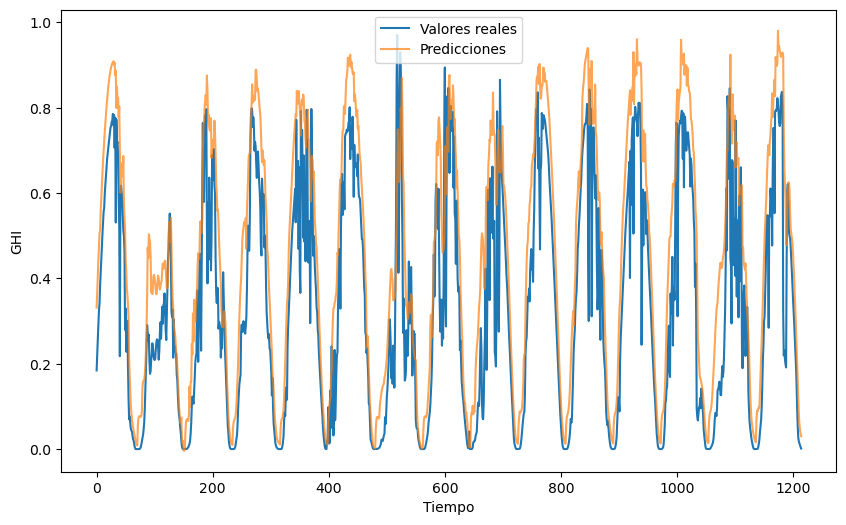

In [15]:
# Probar el modelo
# Preparar el conjunto de prueba
fecha_inicio_prueba = '2023-04-15 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-04-29 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps = 6
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()

In [16]:
import optuna.visualization as vis

# Graficar el historial de optimización
fig_optimization_history = vis.plot_optimization_history(study)
fig_optimization_history.show()

In [17]:
# Graficar la importancia de cada hiperparámetro
fig_param_importances = vis.plot_param_importances(study)
fig_param_importances.show()


In [18]:
# Graficar las coordenadas paralelas para ver las interacciones entre hiperparámetros
fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
fig_parallel_coordinate.show()